
# Sprint 3 — Webinar 7 Teórico  
## Explorar KPIs Financieros con SQL (con esquema *Books*)
<div style="text-align: center">
    <img src="https://raw.githubusercontent.com/ljpiere/tpdata_python/main/images/sp3_1.png" width="400">
</div>

**Duración total:** 1h 20 min  
- Parte 1 (20 min): Fundamentos de BD relacionales (tablas, PK/FK, ERD)  
- Parte 2 (20 min): Consultas básicas — `SELECT`, `WHERE`, `ORDER BY`  
- Parte 3 (25 min): Agregaciones — `GROUP BY`, funciones, cortes por fecha  
- Parte 4 (15 min): Buenas prácticas + precisión con tipos de datos

---

### 🎯 Objetivos de aprendizaje
- Entender la estructura de una BD relacional y su esquema (libros, autores, editoriales, ratings, reviews).  
- Identificar llaves primarias y foráneas.  
- Ejecutar consultas básicas para explorar, filtrar, ordenar y agrupar.  
- Aplicar funciones de fecha y numéricas para KPIs.  
- Detectar problemas de calidad de datos durante la exploración.


### Conexión a la base de datos

In [1]:
from sqlalchemy import create_engine
import pandas as pd

pd.options.display.max_columns = None

db_config = {
 'user': 'practicum_student', # username
 'pwd': 'QnmDH8Sc2TQLvy2G3Vvh7', # password
 'host': 'yp-trainers-practicum.cluster-czs0gxyx2d8w.us-east-1.rds.amazonaws.com',
 'port': 5432, 
 'db': 'data-analyst-final-project-db'
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

engine = create_engine(connection_string, connect_args={'sslmode':'require'})



## 🧠 Introducción a SQL (Structured Query Language)

**SQL** es el lenguaje estándar para **consultar, modificar y analizar** datos en bases de datos relacionales como PostgreSQL, MySQL o SQL Server.

### ¿Qué es SQL?
Es un **lenguaje declarativo**: describes *qué* información necesitas y el motor decide *cómo* obtenerla.

**Ejemplo simple:**
```sql
SELECT title, num_pages
FROM books
WHERE num_pages > 300;
```

### ¿Cómo funciona una consulta?
1. El cliente (Jupyter/IDE) envía la consulta.  
2. El motor SQL la analiza y valida.  
3. El optimizador elige el plan de ejecución (índices, joins, etc.).  
4. Se ejecuta y retorna un **conjunto de filas y columnas**.

### ¿En qué ámbitos se usa?
- **Data Analyst:** extraer, limpiar y resumir datos para KPIs y dashboards.  
- **Data Scientist:** preparar datasets para modelos.  
- **Data Engineer:** construir pipelines sobre RDBMS.  
- **BI / Producto / Finanzas:** consultas directas para métricas de negocio.

En finanzas y negocio se usa para **ingresos, costos, márgenes, ticket promedio, tendencias temporales** y **cohortes**.

### Comandos fundamentales
- `SELECT` (lectura), `WHERE` (filtros), `ORDER BY` (orden), `GROUP BY/HAVING` (agregaciones), `JOIN` (unir tablas), subconsultas, funciones (`COUNT`, `AVG`, `SUM`, `ROUND`, etc.).

La estructura básica de una consulta SQL es:
```sql
SELECT <columnas>
FROM <tabla>
WHERE <filtors>
```

### Importancia para Data Analyst
- Acceso directo a los datos.  
- Respuestas rápidas sin ETL complejo.  
- **KPIs reproducibles** desde fuentes confiables.

**Flujo típico:** SQL (extraer | procesar) → (opcional) Python: Pandas (analisis | procesos avanzados) → Visualización (BI/Notebook).



## 1) Entendiendo el esquema relacional (20 min)

**Tablas y campos principales** (esquema de ejemplo):

- **books**: `book_id` (PK), `author_id` (FK), `title`, `num_pages`, `publication_date`, `publisher_id` (FK)  
- **authors**: `author_id` (PK), `author`  
- **publishers**: `publisher_id` (PK), `publisher`  
- **ratings**: `rating_id` (PK), `book_id` (FK), `username`, `rating`  
- **reviews**: `review_id` (PK), `book_id` (FK), `username`, `text`

> Relaciones clave:  
> `books.author_id` → `authors.author_id`  
> `books.publisher_id` → `publishers.publisher_id`  
> `ratings.book_id` → `books.book_id`  
> `reviews.book_id` → `books.book_id`



**Exploración inicial:** listamos tablas y vemos una muestra de su contenido.


In [2]:

# Listar tablas del esquema (si el usuario tiene permisos)
query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema='public'
ORDER BY table_name;
"""
tables = pd.io.sql.read_sql(query, con=engine)
tables


,table_name
0,advertisment_costs
1,authors
2,books
3,orders
4,publishers
5,ratings
6,reviews
7,users
8,visits


In [ ]:

# Vista rápida de cada tabla clave 
for tbl in ["books", "authors", "publishers", "ratings", "reviews"]:
    try:
        print(f"\n===== {tbl} =====")
        df = pd.io.sql.read_sql(f"SELECT * FROM {tbl} LIMIT 5;", con=engine)
        display(df)
    except Exception as e:
        print(f"⚠️ No se pudo leer {tbl}: {e}")



===== books =====


,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268



===== authors =====


,author_id,author
0,1,A.S. Byatt
1,2,Aesop/Laura Harris/Laura Gibbs
2,3,Agatha Christie
3,4,Alan Brennert
4,5,Alan Moore/David Lloyd



===== publishers =====


,publisher_id,publisher
0,1,Ace
1,2,Ace Book
2,3,Ace Books
3,4,Ace Hardcover
4,5,Addison Wesley Publishing Company



===== ratings =====


,rating_id,book_id,username,rating
0,1,1,ryanfranco,4
1,2,1,grantpatricia,2
2,3,1,brandtandrea,5
3,4,2,lorichen,3
4,5,2,mariokeller,2



===== reviews =====


,review_id,book_id,username,text
0,1,1,brandtandrea,Mention society tell send professor analysis. ...
1,2,1,ryanfranco,Foot glass pretty audience hit themselves. Amo...
2,3,2,lorichen,Listen treat keep worry. Miss husband tax but ...
3,4,3,johnsonamanda,Finally month interesting blue could nature cu...
4,5,3,scotttamara,Nation purpose heavy give wait song will. List...



### 🧩 Ejercicio 1
- Identifica qué columnas pueden funcionar como **PK** y **FK**.  
- ¿Qué preguntas de negocio podrías responder con este esquema? (p. ej., *promedio de calificaciones por editorial*, *cantidad de libros por autor/a*, *evolución anual de publicaciones*).



## 2) Llaves primarias, foráneas y relaciones (10 min)

- **PK (Primary Key):** asegura unicidad por fila (ej. `books.book_id`).  
- **FK (Foreign Key):** referencia a otra tabla (ej. `books.author_id` → `authors.author_id`).  

Estas llaves articulan el modelo relacional y permiten combinar información de diferentes tablas.


In [ ]:

# Catálogo de columnas de 'books'
books_cols = pd.io.sql.read_sql("""
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'books'
ORDER BY ordinal_position;
""", con=engine)
books_cols



### 🧩 Ejercicio 2
Marca (en papel o mentalmente) las relaciones entre `books`, `authors`, `publishers`, `ratings` y `reviews`.  
Piensa cómo combinarías tablas para responder a: “¿Qué editorial publica libros con mejores calificaciones promedio?”


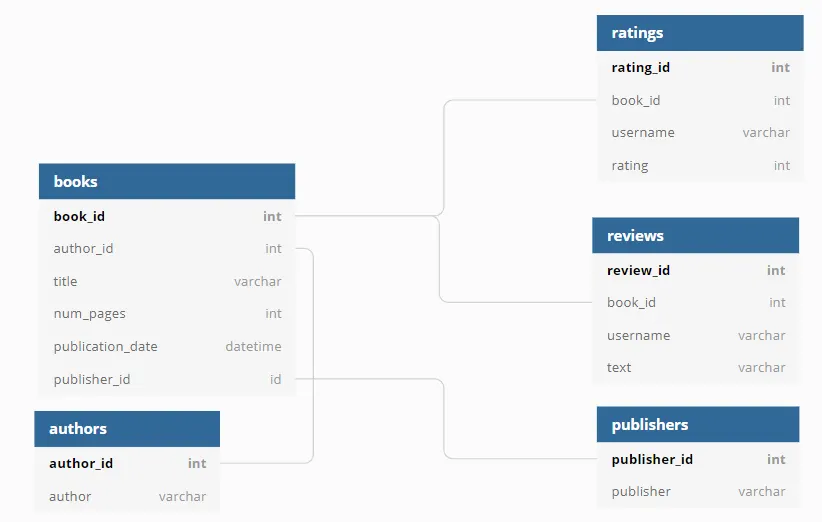


## 3) Inspeccionar tablas con SQL (10 min)

Usaremos consultas sencillas para entender los datos y detectar posibles problemas de calidad (valores nulos, constantes, fechas extrañas).


In [ ]:

# Inspección simple
books = pd.io.sql.read_sql("""
SELECT *
FROM books
LIMIT 10;
""", con=engine)
display(books.head())



**Observa:** tipos de datos, rangos, valores faltantes o atípicos.  
Anota columnas clave para KPIs: `num_pages` (proxy de magnitud), `publication_date` (tiempo), ratings/reviews (calidad/percepción).



## 4) Consultas básicas: `SELECT`, `WHERE`, `ORDER BY` (20 min)


In [ ]:

# Seleccionar columnas específicas
q = """
SELECT book_id, title, num_pages, publication_date
FROM books
LIMIT 10;
"""
res = pd.io.sql.read_sql(q, con=engine)
display(res)


In [ ]:

# Filtrar por condición numérica y fecha
q = """
SELECT book_id, title, num_pages, publication_date
FROM books
WHERE num_pages >= 300
  AND publication_date >= DATE '2000-01-01'
ORDER BY publication_date DESC
LIMIT 20;
"""
res = pd.io.sql.read_sql(q, con=engine)
display(res)



### 🧩 Ejercicio 3
Devuelve todos los libros publicados entre **2010-01-01** y **2020-12-31** con más de **250** páginas, ordenados por `num_pages` descendente.


In [ ]:

# Ordenar resultados: top N por páginas
q = """
SELECT book_id, title, num_pages
FROM books
ORDER BY num_pages DESC
LIMIT 10;
"""
top_pages = pd.io.sql.read_sql(q, con=engine)
display(top_pages)



## 5) Agrupar y agregar datos con `GROUP BY` (25 min)

Funciones agregadas: `COUNT`, `AVG`, `SUM`, `MIN`, `MAX`.  
KPIs ejemplo:  
- Promedio de calificación por libro/editorial.  
- Número de libros por autor/a.  
- Publicaciones por año.


In [ ]:

# Promedio de calificación por libro (si existe tabla ratings)
q = """
SELECT
  r.book_id,
  b.title,
  ROUND(AVG(r.rating), 2) AS avg_rating,
  COUNT(*) AS n_ratings
FROM ratings r
JOIN books b ON b.book_id = r.book_id
GROUP BY r.book_id, b.title
HAVING COUNT(*) >= 5
ORDER BY avg_rating DESC, n_ratings DESC
LIMIT 10;
"""
ratings_by_book = pd.io.sql.read_sql(q, con=engine)
display(ratings_by_book)


In [ ]:

# Libros por autor/a
q = """
SELECT
  a.author,
  COUNT(b.book_id) AS books_count
FROM authors a
LEFT JOIN books b ON b.author_id = a.author_id
GROUP BY a.author
ORDER BY books_count DESC, a.author ASC
LIMIT 10;
"""
books_per_author = pd.io.sql.read_sql(q, con=engine)
display(books_per_author)


In [ ]:

# Publicaciones por año
q = """
SELECT
  DATE_TRUNC('year', publication_date) AS pub_year,
  COUNT(*) AS books_published
FROM books
GROUP BY 1
ORDER BY 1;
"""
pubs_by_year = pd.io.sql.read_sql(q, con=engine)
display(pubs_by_year.head())



### 🧩 Ejercicio 4
Calcula el **promedio de calificación por editorial** (usando `publishers` + `books` + `ratings`) y muestra solo editoriales con **al menos 20 calificaciones**.



## 6) Precisión con tipos y funciones (10–15 min)

- **Fechas:** `DATE_TRUNC('month'/'year', publication_date)` para cortes temporales.  
- **Numéricos:** `ROUND(valor, 2)` para KPIs.  
- **Casting:** `CAST(col AS NUMERIC)` si hay inconsistencias.

> Aunque este esquema no es “financiero puro”, las mismas técnicas aplican para KPIs financieros: ingresos promedio por cliente, margen por categoría, *cohortes* por fecha, etc.


In [ ]:

# Top editoriales por calificación media (umbral mínimo)
q = """
SELECT
  p.publisher,
  ROUND(AVG(r.rating), 2) AS avg_rating,
  COUNT(*) AS n_ratings
FROM ratings r
JOIN books b ON b.book_id = r.book_id
JOIN publishers p ON p.publisher_id = b.publisher_id
GROUP BY p.publisher
HAVING COUNT(*) >= 20
ORDER BY avg_rating DESC, n_ratings DESC
LIMIT 10;
"""
top_publishers = pd.io.sql.read_sql(q, con=engine)
display(top_publishers)



## 7) Buenas prácticas para SQL limpio (10 min)

- Palabras clave en **MAYÚSCULAS** (`SELECT`, `WHERE`, `GROUP BY`).  
- Indentación consistente (una operación por línea).  
- Alias claros (`AS`) y comentarios para lógica compleja.  
- Usa `LIMIT` en exploración para controlar tiempos.  
- Evita `SELECT *` en producción; especifica columnas.  
- Nombres de columnas y tablas coherentes y expresivos.



### Bonus opcional (si hay tiempo): funciones de ventana
Ejemplo de ranking de autores/as por calificación promedio (con umbral de calificaciones).


In [ ]:

q = """
SELECT
  a.author,
  AVG(r.rating) AS avg_rating,
  COUNT(r.rating_id) AS n_ratings
FROM authors a
JOIN books b ON b.author_id = a.author_id
JOIN ratings r ON r.book_id = b.book_id
GROUP BY a.author
HAVING COUNT(r.rating_id) >= 20
ORDER BY avg_rating DESC, n_ratings DESC
LIMIT 10;

"""
author_rank = pd.io.sql.read_sql(q, con=engine)
display(author_rank)


---
### 💡 Tips Generales
1. Empieza simple y *valida filtros* antes de unir/agrupar.  
2. Comenta tu SQL y usa alias claros (`AS`).  
3. Evita `SELECT *` en producción; **especifica columnas**.  
4. Usa `LIMIT` al explorar.  
5. Formatea e indenta para facilitar lectura y mantenimiento.

---
## Cierre



## Siguientes Pasos
- **Próxima sesión:** JOINs, CTEs y subconsultas para KPIs financieros: ingresos por periodo, margen por categoría y retención.
- **Participación continua:** asistir a Co-Learning y a Sprint Focus, y usar los canales de Discord para hacer preguntas.
- **Recordatorios:** la grabación y recursos utilizados, se comparten al finalizar la sesión; en caso de necesitar apoyo adicional, agenda un 1:1.